In [1]:
import gym
import itertools
import matplotlib
import numpy as np
import sys

if "../" not in sys.path:
  sys.path.append("../")

from lib import plotting
from collections import defaultdict
from scipy.stats import beta
from scipy.stats import t
from lib import plotting
import matplotlib.pyplot as plt
from graphviz import Digraph
matplotlib.style.use('ggplot')

num_action = 9
num_state_elements = 6    #num_state_elements = 6
num_state = 2**num_state_elements     #num_state = 100
value_state = defaultdict(lambda: np.zeros(num_state_elements))
space_action = range(num_action)

train_size = 1
num_size = 1000
window_num = 100
#guass_mu, guass_sigma = 3, 2 #   3, 2; 100, 5mean and standard deviation
#beta_a, beta_b=  2, 2
beta_a, beta_b=  1, 1
location = 19.60
scale = 8.08
df = 100
# Creat space of state
for i_pa in range(0, 4):
    for i_va in range(0, 4):
        for i_pb in range(0, 4):
            for i_vb in range(0, 4):
                for i_pd in range(0, 4):
                    for i_vd in range(0, 4):                        
                        index_state = int(i_pa*4**5+i_va*4**4+i_pb*4**3+i_vb*4**2+i_pd*4**1+i_vd)
                        #value_state[index_state]
                        value_state[index_state][0] = i_pa    #value_state[i_pa*8+i_va*4+i_pb*2+i_vb,0] = i_pa * 0.6
                        value_state[index_state][1] = i_va
                        value_state[index_state][2] = i_pb
                        value_state[index_state][3] = i_vb
                        value_state[index_state][4] = i_pd
                        value_state[index_state][5] = i_vd
                        
#print("value_state:",value_state, value_state[2][5])


dtA = Digraph('Decision_TreeA', filename='dtA.gv')
dtA.attr(ratio = "auto") # , size='8,5'

dtB = Digraph('Decision_TreeB', filename='dtB.gv')
dtB.attr(ratio = "auto") # , size='8,5'

dtA997 = Digraph('Decision_TreeA997')
dtA997.attr(ratio = "auto") # , size='8,5'

dtB997 = Digraph('Decision_TreeB997')
dtB997.attr(ratio = "auto") # , size='8,5'

dtA95 = Digraph('Decision_TreeA95')
dtA95.attr(ratio = "auto") # , size='8,5'

dtB95 = Digraph('Decision_TreeB95')
dtB95.attr(ratio = "auto") # , size='8,5'

dtA68 = Digraph('Decision_TreeA68')
dtA68.attr(ratio = "auto") # , size='8,5'

dtB68 = Digraph('Decision_TreeB68')
dtB68.attr(ratio = "auto") # , size='8,5'


class CalculateNode:
    
    def __init__(self, move=None, parent=None, state=None):
        self.move = move
        self.parentNode = parent
        self.childNodes = []
        self.visits = 1
        self.wins = 0
        self.memory = ""
        self.board = [state[col] for col in range(num_state_elements)]

    def Update(self, s, m):
        
        if self.childNodes == []:
            n = CalculateNode(move=m, parent=self, state=s)
            self.childNodes.append(n)
        else:
            child = [c for c in self.childNodes if c.move == m]
            if child == []:
                n = CalculateNode(move=m, parent=self, state=s)
                self.childNodes.append(n)
            else:
                child[0].visits += 1
                n = child[0]
        n.memory = self.memory + str(m)
        return n              
            
    def AddChild(self, s, m):
        """ Remove m from untriedMoves and add a new child node for this move.
            Return the added child node
        """
        n = CalculateNode(move=m, parent=self, state=s)
        self.childNodes.append(n)
        n.memory = self.memory + str(m)
        return n
    
    def __repr__(self):
        return str(self.board) + str(self.visits)

    def TreeToGraph(self, indent, dt, proportions):
        action = int(0)
        s = ""         
        for c in self.childNodes:            
            action = c.move
            label_action = ' '
            if action != 'History ':
                proportions[indent-1][action] += c.visits   

            parent = str(indent-1) + ' ' + self.memory + ' ' + str(self.parentNode) + ' ' + ' ' + str(self.board)
            child = str(indent) + ' ' + c.memory + ' ' + str(c.parentNode) + ' ' +  ' ' + str(c.board)
            if action == space_action[6]:
                dt.node(parent, label=self.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' + str(self.visits))
                dt.node(child, label=c.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' +str(c.visits), style="rounded,filled", fillcolor="springgreen")
            elif action == space_action[7]:
                dt.node(parent, label=self.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' + str(self.visits))
                dt.node(child, label=c.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' +str(c.visits), style="rounded,filled", fillcolor="deepskyblue")
            elif action == space_action[8]:
                dt.node(parent, label=self.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' + str(self.visits))
                dt.node(child, label=c.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' +str(c.visits), style="rounded,filled", fillcolor="firebrick1")
            else:
                dt.node(parent, label=self.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' + str(self.visits))
                dt.node(child, label=c.memory + '\ns=' + str(np.round(c.board, 0)) + '\nn=' +str(c.visits))                    
            #dt.node(parent, label=self.memory + ' ' + str(np.round(self.board, 0)) + ' ' + str(self.visits))
            #dt.node(child, label=c.memory + ' ' + str(np.round(c.board, 0)) + ' ' +str(c.visits))
            if action == space_action[0]:
                label_action = 'PA ? PB'
                dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)), color="blue")
            elif action == space_action[1]:
                label_action = 'PA ? PD'
                dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)), color="blue")
            elif action == space_action[2]:
                label_action = 'PB ? PD'
                dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)), color="blue")
            elif action == space_action[3]:
                label_action = 'VA ? VB'
                dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)), color="red")
            elif action == space_action[4]:
                label_action = 'VA ? VD'
                dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)), color="red")
            elif action == space_action[5]:
                label_action = 'VB ? VD'
                dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)), color="red")
            elif action == space_action[6]:
                label_action = 'Choose A'
                dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)))
            elif action == space_action[7]:
                label_action = 'Choose B'
                dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)))
            elif action == space_action[8]:
                label_action = 'Choose D'
                dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)))
            else:
                dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)))
                
            
            c.TreeToGraph(indent + 1, dt, proportions)
        return s

    def TreeToGraph997(self, indent, dt):
        confidence_num = int(test_num * 100 * 0.003)
        action = int(0)
        s = ""         
        for c in self.childNodes:            
            action = c.move
            label_action = ' '
            if c.visits >= confidence_num:
                parent = str(indent-1) + ' ' + self.memory + ' ' + str(self.parentNode) + ' ' + ' ' + str(self.board)
                child = str(indent) + ' ' + c.memory + ' ' + str(c.parentNode) + ' ' +  ' ' + str(c.board)
                if action == space_action[6]:
                    dt.node(parent, label=self.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' + str(self.visits))
                    dt.node(child, label=c.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' +str(c.visits), style="rounded,filled", fillcolor="springgreen")
                elif action == space_action[7]:
                    dt.node(parent, label=self.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' + str(self.visits))
                    dt.node(child, label=c.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' +str(c.visits), style="rounded,filled", fillcolor="deepskyblue")
                elif action == space_action[8]:
                    dt.node(parent, label=self.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' + str(self.visits))
                    dt.node(child, label=c.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' +str(c.visits), style="rounded,filled", fillcolor="firebrick1")
                else:
                    dt.node(parent, label=self.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' + str(self.visits))
                    dt.node(child, label=c.memory + '\ns=' + str(np.round(c.board, 0)) + '\nn=' +str(c.visits))                    
                #dt.node(parent, label=self.memory + ' ' + str(np.round(self.board, 0)) + ' ' + str(self.visits))
                #dt.node(child, label=c.memory + ' ' + str(np.round(c.board, 0)) + ' ' +str(c.visits))
                if action == space_action[0]:
                    label_action = 'PA ? PB'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)), color="blue")
                elif action == space_action[1]:
                    label_action = 'PA ? PD'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)), color="blue")
                elif action == space_action[2]:
                    label_action = 'PB ? PD'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)), color="blue")
                elif action == space_action[3]:
                    label_action = 'VA ? VB'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)), color="red")
                elif action == space_action[4]:
                    label_action = 'VA ? VD'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)), color="red")
                elif action == space_action[5]:
                    label_action = 'VB ? VD'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)), color="red")
                elif action == space_action[6]:
                    label_action = 'Choose A'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)))
                elif action == space_action[7]:
                    label_action = 'Choose B'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)))
                elif action == space_action[8]:
                    label_action = 'Choose D'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)))
                else:
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)))
                            
            c.TreeToGraph997(indent + 1, dt)
        return s

    def TreeToGraph95(self, indent, dt):
        confidence_num = int(test_num * 100 * 0.05)
        action = int(0)
        s = ""         
        for c in self.childNodes:            
            action = c.move
            label_action = ' '
            if c.visits >= confidence_num:
                parent = str(indent-1) + ' ' + self.memory + ' ' + str(self.parentNode) + ' ' + ' ' + str(self.board)
                child = str(indent) + ' ' + c.memory + ' ' + str(c.parentNode) + ' ' +  ' ' + str(c.board)
                if action == space_action[6]:
                    dt.node(parent, label=self.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' + str(self.visits))
                    dt.node(child, label=c.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' +str(c.visits), style="rounded,filled", fillcolor="springgreen")
                elif action == space_action[7]:
                    dt.node(parent, label=self.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' + str(self.visits))
                    dt.node(child, label=c.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' +str(c.visits), style="rounded,filled", fillcolor="deepskyblue")
                elif action == space_action[8]:
                    dt.node(parent, label=self.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' + str(self.visits))
                    dt.node(child, label=c.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' +str(c.visits), style="rounded,filled", fillcolor="firebrick1")
                else:
                    dt.node(parent, label=self.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' + str(self.visits))
                    dt.node(child, label=c.memory + '\ns=' + str(np.round(c.board, 0)) + '\nn=' +str(c.visits))                    
                #dt.node(parent, label=self.memory + ' ' + str(np.round(self.board, 0)) + ' ' + str(self.visits))
                #dt.node(child, label=c.memory + ' ' + str(np.round(c.board, 0)) + ' ' +str(c.visits))
                if action == space_action[0]:
                    label_action = 'PA ? PB'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)), color="blue")
                elif action == space_action[1]:
                    label_action = 'PA ? PD'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)), color="blue")
                elif action == space_action[2]:
                    label_action = 'PB ? PD'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)), color="blue")
                elif action == space_action[3]:
                    label_action = 'VA ? VB'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)), color="red")
                elif action == space_action[4]:
                    label_action = 'VA ? VD'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)), color="red")
                elif action == space_action[5]:
                    label_action = 'VB ? VD'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)), color="red")
                elif action == space_action[6]:
                    label_action = 'Choose A'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)))
                elif action == space_action[7]:
                    label_action = 'Choose B'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)))
                elif action == space_action[8]:
                    label_action = 'Choose D'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)))
                else:
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)))
                            
            c.TreeToGraph95(indent + 1, dt)
        return s

    def TreeToGraph68(self, indent, dt):
        confidence_num = int(test_num * 100 * 0.1)
        action = int(0)
        s = ""         
        for c in self.childNodes:            
            action = c.move
            label_action = ' '
            if c.visits >= confidence_num:
                parent = str(indent-1) + ' ' + self.memory + ' ' + str(self.parentNode) + ' ' + ' ' + str(self.board)
                child = str(indent) + ' ' + c.memory + ' ' + str(c.parentNode) + ' ' +  ' ' + str(c.board)
                if action == space_action[6]:
                    dt.node(parent, label=self.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' + str(self.visits))
                    dt.node(child, label=c.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' +str(c.visits), style="rounded,filled", fillcolor="springgreen")
                elif action == space_action[7]:
                    dt.node(parent, label=self.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' + str(self.visits))
                    dt.node(child, label=c.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' +str(c.visits), style="rounded,filled", fillcolor="deepskyblue")
                elif action == space_action[8]:
                    dt.node(parent, label=self.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' + str(self.visits))
                    dt.node(child, label=c.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' +str(c.visits), style="rounded,filled", fillcolor="firebrick1")
                else:
                    dt.node(parent, label=self.memory + '\ns=' + str(np.round(self.board, 0)) + '\nn=' + str(self.visits))
                    dt.node(child, label=c.memory + '\ns=' + str(np.round(c.board, 0)) + '\nn=' +str(c.visits))                    
                #dt.node(parent, label=self.memory + ' ' + str(np.round(self.board, 0)) + ' ' + str(self.visits))
                #dt.node(child, label=c.memory + ' ' + str(np.round(c.board, 0)) + ' ' +str(c.visits))
                if action == space_action[0]:
                    label_action = 'PA ? PB'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)), color="blue")
                elif action == space_action[1]:
                    label_action = 'PA ? PD'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)), color="blue")
                elif action == space_action[2]:
                    label_action = 'PB ? PD'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)), color="blue")
                elif action == space_action[3]:
                    label_action = 'VA ? VB'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)), color="red")
                elif action == space_action[4]:
                    label_action = 'VA ? VD'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)), color="red")
                elif action == space_action[5]:
                    label_action = 'VB ? VD'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)), color="red")
                elif action == space_action[6]:
                    label_action = 'Choose A'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)))
                elif action == space_action[7]:
                    label_action = 'Choose B'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)))
                elif action == space_action[8]:
                    label_action = 'Choose D'
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)))
                else:
                    dt.edge(parent, child, label=str(action)+ ':' +label_action + '\nf=' +str(round(c.visits/self.visits, 2)))
                            
            c.TreeToGraph68(indent + 1, dt)
        return s

    def ChildrenToGraph(self):
        dt.node('root', label=str(self))
        action = int(0)
        s = ""
        for c in self.childNodes:
            action = c.move
            dt.node(str(action),label=str(c))
            dt.edge('root',str(action),label=str(action))  
        return s


def Env_calculate_transition_prob(i_sample, current_s, action, ordinal_error,
    value_v_a, value_v_b, value_v_d, value_p_a, value_p_b, value_p_d):
    tolerance_p = 0.011
    #tolerance_v = 8.8
    tolerance_v = 1.1
    #tolerance_v = 0.1
    reward = int(0)
    value_new_state = np.array(value_state[current_s])
    value_e_a = value_p_a * value_v_a
    value_e_b = value_p_b * value_v_b
    value_e_d = value_p_d * value_v_d
    
    ordinal_probs = np.ones(3) * ordinal_error / 2
    ordinal_obs = np.array([1, 2, 3])
    if action == space_action[0]:
        if (value_p_a[i_sample] > value_p_b[i_sample] + tolerance_p):
            ordinal_probs[0] = 1.0 - ordinal_error       
        elif (value_p_a[i_sample] < value_p_b[i_sample] + tolerance_p) and (value_p_a[i_sample] > value_p_b[i_sample] - tolerance_p):
            ordinal_probs[1] = 1.0 - ordinal_error
        else:
            ordinal_probs[2] = 1.0 - ordinal_error
        value_new_state[0] = np.random.choice(ordinal_obs, p=ordinal_probs)
    elif action == space_action[1]:
        if (value_p_a[i_sample] > value_p_d[i_sample] + tolerance_p):
            ordinal_probs[0] = 1.0 - ordinal_error
        elif (value_p_a[i_sample] < value_p_d[i_sample] + tolerance_p) and (value_p_a[i_sample] > value_p_d[i_sample] - tolerance_p):
            ordinal_probs[1] = 1.0 - ordinal_error
        else:
            ordinal_probs[2] = 1.0 - ordinal_error
        value_new_state[1] = np.random.choice(ordinal_obs, p=ordinal_probs)
    elif action == space_action[2]:
        if (value_p_b[i_sample] > value_p_d[i_sample] + tolerance_p):
            ordinal_probs[0] = 1.0 - ordinal_error
        elif (value_p_b[i_sample] < value_p_d[i_sample] + tolerance_p) and (value_p_b[i_sample] > value_p_d[i_sample] - tolerance_p):
            ordinal_probs[1] = 1.0 - ordinal_error
        else:
            ordinal_probs[2] = 1.0 - ordinal_error
        value_new_state[2] = np.random.choice(ordinal_obs, p=ordinal_probs)
    elif action == space_action[3]:
        if (value_v_a[i_sample] > value_v_b[i_sample] + tolerance_v):
            ordinal_probs[0] = 1.0 - ordinal_error
        elif (value_v_a[i_sample] < value_v_b[i_sample] + tolerance_v) and (value_v_a[i_sample] > value_v_b[i_sample] - tolerance_v):
            ordinal_probs[1] = 1.0 - ordinal_error
        else:
            ordinal_probs[2] = 1.0 - ordinal_error
        value_new_state[3] = np.random.choice(ordinal_obs, p=ordinal_probs)
    elif action == space_action[4]:
        if (value_v_a[i_sample] > value_v_d[i_sample] + tolerance_v):
            ordinal_probs[0] = 1.0 - ordinal_error
        elif (value_v_a[i_sample] < value_v_d[i_sample] + tolerance_v) and (value_v_a[i_sample] > value_v_d[i_sample] - tolerance_v):
            ordinal_probs[1] = 1.0 - ordinal_error
        else:
            ordinal_probs[2] = 1.0 - ordinal_error
        value_new_state[4] = np.random.choice(ordinal_obs, p=ordinal_probs)
    elif action == space_action[5]:
        if (value_v_b[i_sample] > value_v_d[i_sample] + tolerance_v):
            ordinal_probs[0] = 1.0 - ordinal_error
        elif (value_v_b[i_sample] < value_v_d[i_sample] + tolerance_v) and (value_v_b[i_sample] > value_v_d[i_sample] - tolerance_v):
            ordinal_probs[1] = 1.0 - ordinal_error
        else:
            ordinal_probs[2] = 1.0 - ordinal_error
        value_new_state[5] = np.random.choice(ordinal_obs, p=ordinal_probs)
    else:
        value_new_state = value_state[current_s]

    new_state =  int(value_new_state[0]*4**5 + value_new_state[1]*4**4 +
                  value_new_state[2]*4**3 + value_new_state[3]*4**2 +
                  value_new_state[4]*4**1 + value_new_state[5])
    
    maximum_ev = np.max([value_e_a[i_sample], value_e_b[i_sample], value_e_d[i_sample]])
    if action == space_action[6]:
        is_done = True
        reward = 10 if value_e_a[i_sample] == maximum_ev else -10
        #reward = value_e_a[i_sample]
        #reward = np.random.choice([value_v_a[i_sample], 0], p=[value_p_a[i_sample], 1 - value_p_a[i_sample]])
    elif action == space_action[7]:
        is_done = True
        reward = 10 if value_e_b[i_sample] == maximum_ev else -10
        #reward = value_e_b[i_sample]
        #reward = np.random.choice([value_v_b[i_sample], 0], p=[value_p_b[i_sample], 1 - value_p_b[i_sample]])
    elif action == space_action[8]:
        is_done = True
        reward = 10 if value_e_d[i_sample] == maximum_ev else -10
        #reward = value_e_d[i_sample]
        #reward = np.random.choice([value_v_d[i_sample], 0], p=[value_p_d[i_sample], 1 - value_p_d[i_sample]])
    else:
        is_done = False
        reward = -1
    
    #reward = 100.0 if (new_state == num_state - 1) else -1.0
    return new_state, reward, is_done


def make_epsilon_greedy_policy(Q, nA):
    def policy_fn(observation, epsilon):
        #'''
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
        #'''
        '''
        value_current_state = np.array(value_state[observation])
        available_action = [ac for ac in range(num_state_elements) if value_current_state[ac] == 0] + [6, 7, 8]
        nA = len(available_action)
        A = np.zeros(num_action)
        A[available_action] = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
        '''
    return policy_fn

def GenerateData(decoy):
    is_mached = False
    from scipy.stats import t
    while is_mached !=True:
        test_v_a = t.rvs(df, location, scale, 1)
        test_v_b = t.rvs(df, location, scale, 1)
        test_v_d = t.rvs(df, location, scale, 1)
        #test_v_a = np.random.normal(guass_mu, guass_sigma, 1)
        #test_v_b = np.random.normal(guass_mu, guass_sigma, 1)
        #test_v_d = np.random.normal(guass_mu, guass_sigma, 1)       
        test_p_a = np.random.beta(beta_a, beta_b, 1)
        test_p_b = np.random.beta(beta_a, beta_b, 1)
        test_p_d = np.random.beta(beta_a, beta_b, 1)
 
        if decoy == 0:
            if (test_p_a[0] > test_p_d[0]) and (test_p_d[0] > test_p_b[0]) and (test_v_b[0] > test_v_a[0]) and (test_v_a[0] > test_v_d[0]):
                is_mached = True
                return round(test_v_a[0], 2), round(test_v_b[0], 2), round(test_v_d[0], 2), round(test_p_a[0], 2), round(test_p_b[0], 2), round(test_p_d[0],2)
            else:
                is_mached = False
        else:
            if (test_p_a[0] > test_p_b[0]) and (test_p_b[0] > test_p_d[0]) and (test_v_b[0] > test_v_d[0]) and (test_v_d[0] > test_v_a[0]):
                is_mached = True
                return round(test_v_a[0], 2), round(test_v_b[0], 2), round(test_v_d[0], 2), round(test_p_a[0], 2), round(test_p_b[0], 2), round(test_p_d[0],2)
            else:
                is_mached = False

def test_accuracy(Q, decoy, statis, ordinal_error):
    test_size = 100
    test_v_a = np.zeros(test_size)
    test_v_b = np.zeros(test_size)
    test_v_d = np.zeros(test_size)
    test_p_a = np.zeros(test_size)
    test_p_b = np.zeros(test_size)
    test_p_d = np.zeros(test_size)
    for i_test in range(test_size):
        test_v_a[i_test], test_v_b[i_test], test_v_d[i_test], test_p_a[i_test], test_p_b[i_test], test_p_d[i_test] = GenerateData(decoy)
    
    test_e_a = test_p_a * test_v_a
    test_e_b = test_p_b * test_v_b
    test_e_d = test_p_d * test_v_d

    choice_calculate = np.zeros(3)
    choice_true = 0
    #calculative_reward = 0
    rational_choice = np.zeros(3)
    #episode_lengths = np.zeros(test_size)
    episode_lengths = 1
    
    for i_test in range(test_size):
        state = 0
        done = 0
        action = 'History '
        if decoy == 0:
            statis = rootstatis0
        else:
            statis = rootstatis1
            
        value_new_state = np.array(value_state[state])
        statis = statis.Update(value_new_state, action)                        
        for t in itertools.count():

            policy = make_epsilon_greedy_policy(Q, num_action) 
            action_probs = policy(state, 0.0)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done =  Env_calculate_transition_prob(i_test, state, action, ordinal_error,
            test_v_a, test_v_b, test_v_d, test_p_a, test_p_b, test_p_d)
            value_new_state = np.array(value_state[next_state])
            statis = statis.Update(value_new_state, action)

            if done or t == 10:
                episode_lengths += t + 1
                break
        
            state = next_state
        
        best_action = action
        if best_action == 6:
            choice_calculate[0] += 1
        elif best_action == 7:
            choice_calculate[1] += 1
        elif best_action == 8:
            choice_calculate[2] += 1

        max_EV = np.argmax([test_e_a[i_test], test_e_b[i_test], test_e_d[i_test]])
        if max_EV == 0:
            rational_choice[0] += 1
        elif max_EV == 1:
            rational_choice[1] += 1
        elif max_EV == 2:
            rational_choice[2] += 1

        if best_action == (max_EV + 6): choice_true += 1

    choice_accuracy = choice_true / test_size
    choice_calculate = choice_calculate / np.sum(choice_calculate)
    rational_choice = rational_choice / test_size
    episode_lengths = episode_lengths / test_size

    return choice_accuracy, choice_calculate, rational_choice, episode_lengths


def q_learning(num_episodes, discount_factor=0.9, alpha=0.1, ordinal_error = 0.0, 
               epsilon_start=1.0, epsilon_end=0.05, epsilon_decay_steps=500):
    
    Q = defaultdict(lambda: np.zeros(num_action))

    # The epsilon decay schedule
    epsilons = np.linspace(epsilon_start, epsilon_end, epsilon_decay_steps)
    policy = make_epsilon_greedy_policy(Q, num_action)
    epsilon = epsilon_start

    for i_episode in range(num_episodes):

        from scipy.stats import t
        value_v_a = t.rvs(df, location, scale, num_size)
        value_v_b = t.rvs(df, location, scale, num_size)
        value_v_d = t.rvs(df, location, scale, num_size) 
        #value_v_a = np.random.normal(guass_mu, guass_sigma, num_size)
        #value_v_b = np.random.normal(guass_mu, guass_sigma, num_size)
        #value_v_d = np.random.normal(guass_mu, guass_sigma, num_size)
        value_p_a = np.random.beta(beta_a, beta_b,num_size)
        value_p_b = np.random.beta(beta_a, beta_b,num_size)
        value_p_d = np.random.beta(beta_a, beta_b,num_size)
        value_v_a = np.round(value_v_a, 2)
        value_v_b = np.round(value_v_b, 2)
        value_v_d = np.round(value_v_d, 2)
        value_p_a = np.round(value_p_a, 2)
        value_p_b = np.round(value_p_b, 2)
        value_p_d = np.round(value_p_d, 2)

        value_e_a = value_p_a * value_v_a
        value_e_b = value_p_b * value_v_b
        value_e_d = value_p_d * value_v_d
        max_EV = np.zeros(num_size)

        t_length = 0

        for i_sample in range(num_size):

            state = 0
            max_EV[i_sample] = np.max([value_e_a[i_sample], value_e_b[i_sample], value_e_d[i_sample]])

            for t_length in itertools.count():

                # Epsilon for this time step
                epsilon = epsilons[min(i_episode, epsilon_decay_steps-1)]
                action_probs = policy(state, epsilon)
                action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
                next_state, reward, done =  Env_calculate_transition_prob(i_sample, state, action, ordinal_error,
                    value_v_a, value_v_b, value_v_d, value_p_a, value_p_b, value_p_d)
               
                best_next_action = np.argmax(Q[next_state])
                td_target = reward + discount_factor * Q[next_state][best_next_action]                
                td_delta = td_target - Q[state][action]
                #print(td_delta)
                Q[state][action] += alpha * td_delta
                
                if done or t_length == 10:
                    break

                state = next_state                 
    return Q  


In [2]:
err_num = 6
test_num = 20
ordinal_err = np.linspace(0.0, 0.5, err_num)
proportions_DB = np.zeros((11, num_action))
rootstate = 0
value_rootstate = np.array(value_state[rootstate])
rootstatis0 = CalculateNode(state=value_rootstate)
rootstatis1 = CalculateNode(state=value_rootstate)
statis0 = rootstatis0
statis1 = rootstatis1
model_choice_A_DA = np.zeros((err_num, test_num))
model_choice_B_DA = np.zeros((err_num, test_num))
model_choice_D_DA = np.zeros((err_num, test_num))
model_choice_A_DB = np.zeros((err_num, test_num))
model_choice_B_DB = np.zeros((err_num, test_num))
model_choice_D_DB = np.zeros((err_num, test_num))
for i_err in range(err_num):
    if (i_err + 1) % 1 == 0:
        print("\ri_err {}/{}.".format(i_err + 1, err_num), end="") 
    
    model_accuracy_DA = np.zeros(test_num)
    model_accuracy_DB = np.zeros(test_num)
    model_choice_DA = np.zeros((test_num, 3))
    model_choice_DB = np.zeros((test_num, 3))
    model_t_lengths_DA = np.zeros(test_num)
    model_t_lengths_DB = np.zeros(test_num)
    test_rational_choice_DA = np.zeros((test_num, 3))
    test_rational_choice_DB = np.zeros((test_num, 3))

    proportions_DA = np.zeros((11, num_action))

    for i_model in range(test_num):
                   
        Q = q_learning(num_episodes = 1000, ordinal_error = ordinal_err[i_err])
        #plotting.plot_episode_stats(stats)
        model_accuracy_DA[i_model], model_choice_DA[i_model], test_rational_choice_DA[i_model], model_t_lengths_DA[i_model] = test_accuracy(Q, 0, statis0, ordinal_error = ordinal_err[i_err])
        model_accuracy_DB[i_model], model_choice_DB[i_model], test_rational_choice_DB[i_model], model_t_lengths_DB[i_model] = test_accuracy(Q, 1, statis1, ordinal_error = ordinal_err[i_err])

    model_choice_A_DA[i_err] = [model_choice_DA[i][0] for i in range(test_num)]
    model_choice_B_DA[i_err] = [model_choice_DA[i][1] for i in range(test_num)]
    model_choice_D_DA[i_err] = [model_choice_DA[i][2] for i in range(test_num)]
    model_choice_A_DB[i_err] = [model_choice_DB[i][0] for i in range(test_num)]
    model_choice_B_DB[i_err] = [model_choice_DB[i][1] for i in range(test_num)]
    model_choice_D_DB[i_err] = [model_choice_DB[i][2] for i in range(test_num)]

print(model_choice_A_DA)
print(model_choice_B_DA)
print(model_choice_D_DA)
print(model_choice_A_DB)
print(model_choice_B_DB)
print(model_choice_D_DB)

i_err 6/6.[[0.99       1.         1.         1.         1.         1.
  0.99       1.         1.         0.99       1.         1.
  1.         0.96       1.         1.         1.         0.99
  1.         1.        ]
 [0.86734694 0.91954023 0.82608696 0.86315789 0.79569892 0.88888889
  0.87       0.85869565 0.49206349 0.8877551  0.89473684 0.88043478
  0.78350515 0.84444444 0.84       0.86868687 0.93181818 0.86
  0.87       0.91954023]
 [0.7012987  0.85869565 0.82954545 0.80434783 0.89247312 0.74418605
  0.81111111 0.43103448 0.25862069 0.84693878 0.77777778 0.77083333
  0.75       0.85185185 0.76404494 0.83505155 0.7826087  0.71134021
  0.83870968 0.77027027]
 [0.69230769 0.81818182 0.8        0.66666667 0.74576271 0.74242424
  0.82352941 0.6        0.66666667 0.70588235 0.66666667 0.86363636
  0.86075949 0.68831169 0.6056338  0.78125    0.69047619 0.72619048
  0.8852459  0.66666667]
 [0.3902439  0.44776119 0.48275862 0.49090909 0.45       0.79310345
  0.68085106 0.5        0.81967213

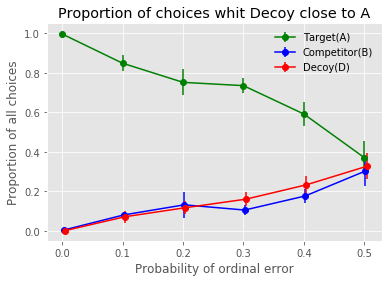

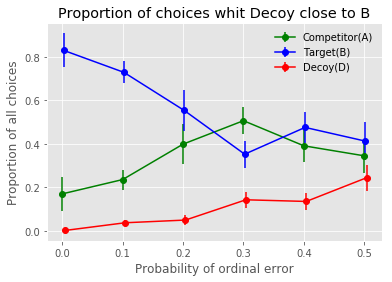

In [3]:

std_choice_A_DA = np.std(model_choice_A_DA, axis=1, ddof=1) / np.sqrt(test_num)
std_choice_B_DA = np.std(model_choice_B_DA, axis=1, ddof=1) / np.sqrt(test_num)
std_choice_D_DA = np.std(model_choice_D_DA, axis=1, ddof=1) / np.sqrt(test_num)
std_choice_A_DB = np.std(model_choice_A_DB, axis=1, ddof=1) / np.sqrt(test_num)
std_choice_B_DB = np.std(model_choice_B_DB, axis=1, ddof=1) / np.sqrt(test_num)
std_choice_D_DB = np.std(model_choice_D_DB, axis=1, ddof=1) / np.sqrt(test_num)
mean_choice_A_DA = np.mean(model_choice_A_DA, axis=1)
mean_choice_B_DA = np.mean(model_choice_B_DA, axis=1)
mean_choice_D_DA = np.mean(model_choice_D_DA, axis=1)
mean_choice_A_DB = np.mean(model_choice_A_DB, axis=1)
mean_choice_B_DB = np.mean(model_choice_B_DB, axis=1)
mean_choice_D_DB = np.mean(model_choice_D_DB, axis=1)
Confidence_Intervals_choice_A_DA = 1.96 * std_choice_A_DA
Confidence_Intervals_choice_B_DA = 1.96 * std_choice_B_DA
Confidence_Intervals_choice_D_DA = 1.96 * std_choice_D_DA
Confidence_Intervals_choice_A_DB = 1.96 * std_choice_A_DB
Confidence_Intervals_choice_B_DB = 1.96 * std_choice_B_DB
Confidence_Intervals_choice_D_DB = 1.96 * std_choice_D_DB
axis_control = np.ones(err_num) * 0.002
fig1 = plt.figure(1)
plt.errorbar(ordinal_err, mean_choice_A_DA, yerr=Confidence_Intervals_choice_A_DA, ecolor = 'g', fmt='g-o', label = 'Target(A)')
plt.errorbar(ordinal_err + axis_control, mean_choice_B_DA, yerr=Confidence_Intervals_choice_B_DA, ecolor = 'b', fmt='b-o', label = 'Competitor(B)')
plt.errorbar(ordinal_err + axis_control*2, mean_choice_D_DA, yerr=Confidence_Intervals_choice_D_DA, ecolor = 'r', fmt='r-o', label = 'Decoy(D)')
plt.legend(loc='best', frameon=False)
plt.xlabel("Probability of ordinal error")
plt.ylabel("Proportion of all choices")
plt.title('Proportion of choices whit Decoy close to A')
plt.show(fig1)
fig2 = plt.figure(2)
plt.errorbar(ordinal_err, mean_choice_A_DB, yerr=Confidence_Intervals_choice_A_DB, ecolor = 'g', fmt='g-o', label = 'Competitor(A)')
plt.errorbar(ordinal_err + axis_control, mean_choice_B_DB, yerr=Confidence_Intervals_choice_B_DB, ecolor = 'b', fmt='b-o', label = 'Target(B)')
plt.errorbar(ordinal_err + axis_control*2, mean_choice_D_DB, yerr=Confidence_Intervals_choice_D_DB, ecolor = 'r', fmt='r-o', label = 'Decoy(D)')
plt.legend(loc='best', frameon=False)
plt.xlabel("Probability of ordinal error")
plt.ylabel("Proportion of all choices")
plt.title('Proportion of choices whit Decoy close to B')
plt.show(fig2)

In [ ]:
err_num = 6
ordinal_err = np.linspace(0.0, 0.5, err_num)
print(ordinal_err)

In [ ]:
np.std(model_choice_A_DA, axis=1, ddof=1)/np.sqrt(err_num)

In [ ]:
np.mean(model_choice_A_DA, axis=1)

In [ ]:
import statistics
statistics.stdev(model_choice_A_DA[2])

In [ ]:
#Test the model after training
ordinal_err = 0.0
test_num = 2
model_accuracy_DA = np.zeros(test_num)
model_accuracy_DB = np.zeros(test_num)
model_choice_DA = np.zeros((test_num, 3))
model_choice_DB = np.zeros((test_num, 3))
model_t_lengths_DA = np.zeros(test_num)
model_t_lengths_DB = np.zeros(test_num)
test_rational_choice_DA = np.zeros((test_num, 3))
test_rational_choice_DB = np.zeros((test_num, 3))
proportions_DA = np.zeros((11, num_action))
proportions_DB = np.zeros((11, num_action))
rootstate = 0
value_rootstate = np.array(value_state[rootstate])
rootstatis0 = CalculateNode(state=value_rootstate)
rootstatis1 = CalculateNode(state=value_rootstate)
statis0 = rootstatis0
statis1 = rootstatis1
for i_model in range(test_num):
    if (i_model + 1) % 1 == 0:
        print("\ri_model {}/{}.".format(i_model + 1, test_num), end="")            
    Q = q_learning(num_episodes = 1000, ordinal_error = ordinal_err)
    #plotting.plot_episode_stats(stats)
    model_accuracy_DA[i_model], model_choice_DA[i_model], test_rational_choice_DA[i_model], model_t_lengths_DA[i_model] = test_accuracy(Q, 0, statis0, ordinal_error = ordinal_err)
    model_accuracy_DB[i_model], model_choice_DB[i_model], test_rational_choice_DB[i_model], model_t_lengths_DB[i_model] = test_accuracy(Q, 1, statis1, ordinal_error = ordinal_err)


In [ ]:
rootstatis0.TreeToGraph(0, dtA, proportions_DA)
rootstatis1.TreeToGraph(0, dtB, proportions_DB)
rootstatis0.TreeToGraph997(0, dtA997)
rootstatis1.TreeToGraph997(0, dtB997)
rootstatis0.TreeToGraph95(0, dtA95)
rootstatis1.TreeToGraph95(0, dtB95)
rootstatis0.TreeToGraph68(0, dtA68)
rootstatis1.TreeToGraph68(0, dtB68)
dtA.render(filename='dtAGauss.gv')
dtB.render(filename='dtBGauss.gv')
dtA997.render(filename='dtAGauss997.gv')
dtB997.render(filename='dtBGauss997.gv')
dtA95.render(filename='dtAGauss95.gv')
dtB95.render(filename='dtBGauss95.gv')
dtA68.render(filename='dtAGauss68.gv')
dtB68.render(filename='dtBGauss68.gv')

print("proportions_DA:", proportions_DA)
print("proportions_DB:", proportions_DB)
print('guass distribution')
print("model_accuracy_DA:",model_accuracy_DA)
print("model_choice_DA:",model_choice_DA)
print("test_rational_choice_DA:",test_rational_choice_DA)
print("model_accuracy_DB:",model_accuracy_DB)
print("model_choice_DB:",model_choice_DB)
print("test_rational_choice_DB:",test_rational_choice_DB)
print("Test number_DA:", model_t_lengths_DA)
print("Test number_DB:", model_t_lengths_DB)


fig11 = plt.figure(11, figsize=(6,7))
n_teps = 7
data = np.zeros((num_action, n_teps))
# Get some pastel shades for the colors
colors = ['xkcd:sky blue', 'xkcd:cyan', 'xkcd:bright blue', 'xkcd:fuchsia', 'xkcd:light red', 
          'xkcd:light pink', 'g', 'xkcd:royal blue', 'w'] 
#'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive'
#colors = plt.cm.BuPu(np.linspace(0, 0.5, num_action))
index = np.arange(n_teps) + 0.3
bar_width = 0.6
# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(n_teps)
# Plot bars and create text labels for the table
cell_text = []
columns = ['S %d' % x for x in range(n_teps)]
rows = ('D', 'B', 'A', 'VB?VD', 'VA?VD', 'VA?VB', 'PB?PD', 'PA?PD', 'PA?PB')
for row in range(num_action):
    data[row] = [proportions_DA[i][row]/np.sum(proportions_DA[i]) for i in range(n_teps)]
    plt.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + data[row]
    cell_text.append(['%1.2f' % x for x in data[row]])
# Reverse colors and text labels to display the last value at the top.
colors = colors[::-1]
cell_text.reverse()

# Add a table at the bottom of the axes
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom')    
# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.25)
#plt.ylabel("Loss in ${0}'s".format(value_increment))
plt.yticks(np.arange(0, 1.3, 0.1))
plt.xticks([])
plt.title('The proportion of each action (close to A)')
plt.show(fig11)


fig12 = plt.figure(12, figsize=(6,7))
n_teps = 7
data = np.zeros((num_action, n_teps))
# Get some pastel shades for the colors
colors = ['xkcd:sky blue', 'xkcd:cyan', 'xkcd:bright blue', 'xkcd:fuchsia', 'xkcd:light red', 
          'xkcd:light pink', 'g', 'xkcd:royal blue', 'w'] 
#'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive'
#colors = plt.cm.BuPu(np.linspace(0, 0.5, num_action))
index = np.arange(n_teps) + 0.3
bar_width = 0.6
# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(n_teps)
# Plot bars and create text labels for the table
cell_text = []
columns = ['S %d' % x for x in range(n_teps)]
rows = ('D', 'B', 'A', 'VB?VD', 'VA?VD', 'VA?VB', 'PB?PD', 'PA?PD', 'PA?PB')
for row in range(num_action):
    data[row] = [proportions_DB[i][row]/np.sum(proportions_DB[i]) for i in range(n_teps)]
    plt.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + data[row]
    cell_text.append(['%1.2f' % x for x in data[row]])
# Reverse colors and text labels to display the last value at the top.
colors = colors[::-1]
cell_text.reverse()

# Add a table at the bottom of the axes
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom')    
# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.25)
#plt.ylabel("Loss in ${0}'s".format(value_increment))
plt.yticks(np.arange(0, 1.3, 0.1))
plt.xticks([])
plt.title('The proportion of each action(close to B)')
plt.show(fig12)


fig1 = plt.figure(1)
plt.plot(model_accuracy_DA)
plt.axis([0, test_num, 0, 1])
plt.xlabel("Model sequential number")
plt.ylabel("Rate of choice accuracy")
plt.title("Accuracy of the model with the Decoy close to A")
plt.show(fig1)

fig9 = plt.figure(9)

plt.plot(model_t_lengths_DA)
plt.axis([0, test_num, 0, 11])
plt.xlabel("Model sequential number")
plt.ylabel("Average number of action")
plt.title("Average number of action with the Decoy close to A")
plt.show(fig9)


fig2, ax = plt.subplots()

model_choice_A_DA = [model_choice_DA[i][0] for i in range(test_num)]
model_choice_B_DA = [model_choice_DA[i][1] for i in range(test_num)]
model_choice_D_DA = [model_choice_DA[i][2] for i in range(test_num)]

total_choice_A = np.sum(model_choice_A_DA) / test_num
total_choice_B = np.sum(model_choice_B_DA) / test_num
total_choice_D = np.sum(model_choice_D_DA) / test_num

ind = range(3)
proportions = [total_choice_A, total_choice_B, total_choice_D]
fa, fb, fd = plt.bar(ind, proportions) #alpha=0.8
fa.set_facecolor('g')
fb.set_facecolor('b')
fd.set_facecolor('r')
ax.set_xticks(ind)
ax.set_xticklabels(['A', 'B', 'D'])
ax.set_ylim([0, 1])
ax.set_ylabel('Proportion of choices')
ax.set_title('Average proportions with the Decoy close to A')
for x,y in enumerate(proportions):
    plt.text(x, y+0.02, '%s' % round(y, 2), ha='center')
#plt.xticks(x, ('A', 'B', 'D'))
plt.show(fig2)


fig3, ax = plt.subplots()

rational_choice_A = [test_rational_choice_DA[i][0] for i in range(test_num)]
rational_choice_B = [test_rational_choice_DA[i][1] for i in range(test_num)]
rational_choice_D = [test_rational_choice_DA[i][2] for i in range(test_num)]

total_choice_A = np.sum(rational_choice_A) / test_num
total_choice_B = np.sum(rational_choice_B) / test_num
total_choice_D = np.sum(rational_choice_D) / test_num

ind = range(3)
proportions = [total_choice_A, total_choice_B, total_choice_D]
fa, fb, fd = plt.bar(ind, proportions) #alpha=0.8
fa.set_facecolor('g')
fb.set_facecolor('b')
fd.set_facecolor('r')
ax.set_xticks(ind)
ax.set_xticklabels(['A', 'B', 'D'])
ax.set_ylim([0, 1])
ax.set_ylabel('Proportion of rational choices')
ax.set_title('Average of the proportions with the Decoy close to A')
for x,y in enumerate(proportions):
    plt.text(x, y+0.02, '%s' % round(y, 2), ha='center')
#plt.xticks(x, ('A', 'B', 'D'))
plt.show(fig3)


fig4 = plt.figure(4)
plt.plot(model_choice_A_DA, 'g.')
plt.plot(model_choice_B_DA, 'b.')
plt.plot(model_choice_D_DA, 'r.')
plt.title("Choice of the model with the Decoy close to A")
plt.show(fig4)

fig14, ax = plt.subplots()
ax.hist(model_choice_A_DA, 30, color="g", histtype='stepfilled', alpha=0.6)
ax.hist(model_choice_B_DA, 30, color="b", histtype='stepfilled', alpha=0.6)
ax.hist(model_choice_D_DA, 30, color="r", histtype='stepfilled', alpha=0.6)
#plt.hist(value_e_a, 300, color="r", normed=True)
plt.show(fig14)


fig5 = plt.figure(5)
plt.plot(model_accuracy_DB)
plt.axis([0, test_num, 0, 1])
plt.xlabel("Model sequential number")
plt.ylabel("Rate of choice accuracy")
plt.title("Accuracy of the model with the Decoy close to B")
plt.show(fig1)

fig10 = plt.figure(10)

plt.plot(model_t_lengths_DB)
plt.axis([0, test_num, 0, 11])
plt.xlabel("Model sequential number")
plt.ylabel("Average number of action")
plt.title("Average number of action with the Decoy close to B")
plt.show(fig10)


fig6, ax = plt.subplots()

model_choice_A_DB = [model_choice_DB[i][0] for i in range(test_num)]
model_choice_B_DB = [model_choice_DB[i][1] for i in range(test_num)]
model_choice_D_DB = [model_choice_DB[i][2] for i in range(test_num)]

total_choice_A = np.sum(model_choice_A_DB) / test_num
total_choice_B = np.sum(model_choice_B_DB) / test_num
total_choice_D = np.sum(model_choice_D_DB) / test_num

ind = range(3)
proportions = [total_choice_A, total_choice_B, total_choice_D]
fa, fb, fd = plt.bar(ind, proportions) #alpha=0.8
fa.set_facecolor('g')
fb.set_facecolor('b')
fd.set_facecolor('r')
ax.set_xticks(ind)
ax.set_xticklabels(['A', 'B', 'D'])
ax.set_ylim([0, 1])
ax.set_ylabel('Proportion of choices')
ax.set_title('Average of the proportions with the Decoy close to B')
for x,y in enumerate(proportions):
    plt.text(x, y+0.02, '%s' % round(y, 2), ha='center')
#plt.xticks(x, ('A', 'B', 'D'))
plt.show(fig6)


fig7, ax = plt.subplots()

rational_choice_A = [test_rational_choice_DB[i][0] for i in range(test_num)]
rational_choice_B = [test_rational_choice_DB[i][1] for i in range(test_num)]
rational_choice_D = [test_rational_choice_DB[i][2] for i in range(test_num)]

total_choice_A = np.sum(rational_choice_A) / test_num
total_choice_B = np.sum(rational_choice_B) / test_num
total_choice_D = np.sum(rational_choice_D) / test_num

ind = range(3)
proportions = [total_choice_A, total_choice_B, total_choice_D]
fa, fb, fd = plt.bar(ind, proportions) #alpha=0.8
fa.set_facecolor('g')
fb.set_facecolor('b')
fd.set_facecolor('r')
ax.set_xticks(ind)
ax.set_xticklabels(['A', 'B', 'D'])
ax.set_ylim([0, 1])
ax.set_ylabel('Proportion of rational choices')
ax.set_title('Average of the proportions with the Decoy close to B')
for x,y in enumerate(proportions):
    plt.text(x, y+0.02, '%s' % round(y, 2), ha='center')
#plt.xticks(x, ('A', 'B', 'D'))
plt.show(fig7)


fig8 = plt.figure(8)
plt.plot(model_choice_A_DB, 'g.')
plt.plot(model_choice_B_DB, 'b.')
plt.plot(model_choice_D_DB, 'r.')
plt.title("Choice of the model with the Decoy close to B")
plt.show(fig8)


fig13, ax = plt.subplots()
ax.hist(model_choice_A_DB, 100, color="g", histtype='bar', alpha=0.6)
ax.hist(model_choice_B_DB, 100, color="b", histtype='bar', alpha=0.6)
ax.hist(model_choice_D_DB, 100, color="r", histtype='stepfilled', alpha=0.6)
#plt.hist(value_e_a, 300, color="r", normed=True)
plt.show(fig13)


#print(len(Q))    
#plotting.plot_episode_stats(stats)
#print(Q[346], Q[400])
